## Taxi Zones dataset

In [1]:
import geopandas as gpd
import pandas as pd
import sys

sys.path.append("../..")

from configs.data_configs import RAW_DATA_DIR

# Load the taxi zones shapefile
taxi_zones = gpd.read_file(RAW_DATA_DIR / "taxi_zones/taxi_zones.shp")
print(taxi_zones.shape)
taxi_zones.head()

(263, 7)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


## visulaizing geometry polygons

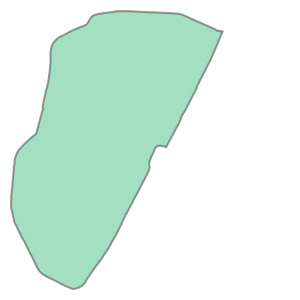

In [2]:
taxi_zones["geometry"][0]

## visualizing multiple polygons

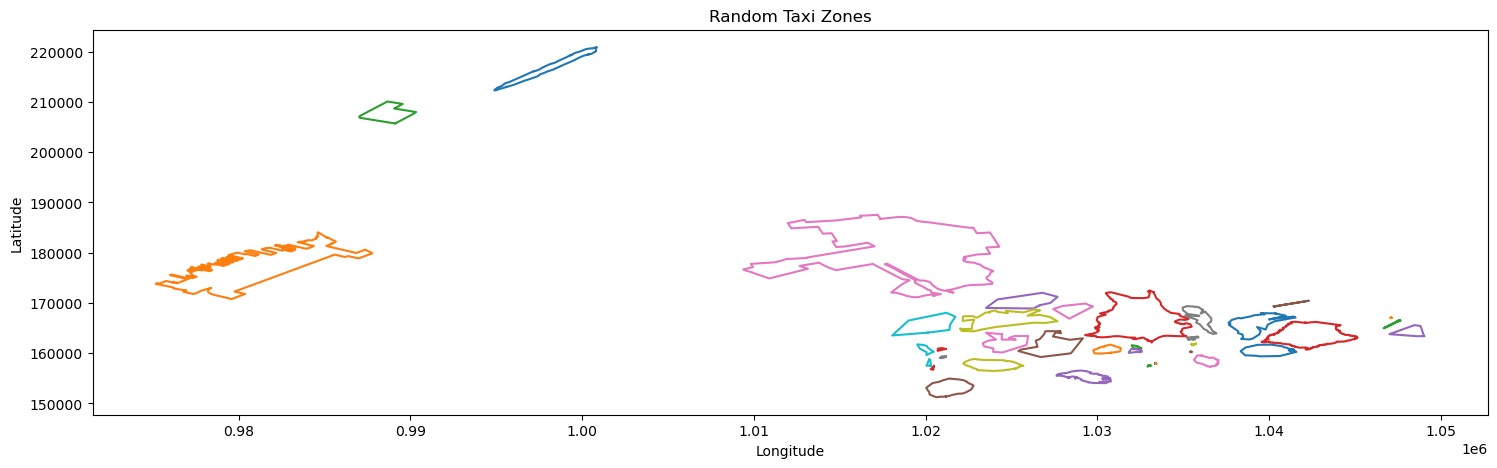

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon

np.random.seed(6)  # Set a random seed for reproducibility
plt.figure(figsize=(18, 5))  # Set the size of the plot

for j in range(5):
    i = np.random.randint(0, len(taxi_zones))
    geometry = taxi_zones["geometry"][i]

    # Check if the geometry is a MultiPolygon or a Polygon
    if isinstance(geometry, MultiPolygon):
        for polygon in geometry.geoms:
            x, y = polygon.exterior.xy
            plt.plot(x, y)
    else:
        x, y = geometry.exterior.xy
        plt.plot(x, y)
plt.title("Random Taxi Zones")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

This code below performs a series of operations on the `taxi_zones` dataset, which is a GeoDataFrame containing geographical data (likely polygons, multi-polygons representing different taxi zones). Here's an explanation of each step:

### 1. **Reproject to a Projected Coordinate Reference System (CRS)**
   ```python
   taxi_zones = taxi_zones.to_crs(epsg=2263)  # UTM New York State Plane (EPSG:2263)
   ```
   - **Purpose**: Reprojects the geometries of the `taxi_zones` GeoDataFrame to a projected coordinate system (CRS). The `epsg=2263` refers to the **New York State Plane (UTM Zone 18N)**, which uses meters as units, making it more suitable for accurate distance and area calculations than latitude/longitude (WGS84, EPSG:4326).
   - **Why this is needed**: When calculating distances, areas, or centroids, it's better to use a projected CRS (which uses meters or feet) instead of a geographic CRS (latitude/longitude) to avoid inaccuracies due to the curvature of the Earth.

### 2. **Calculate Centroids**
   ```python
   taxi_zones['centroid'] = taxi_zones.geometry.centroid
   ```
   - **Purpose**: Computes the centroid of each geometry (polygon) in the `taxi_zones` GeoDataFrame.
   - **Why this is needed**: The centroid represents the "center" of each polygon and can be used for various analyses, such as finding the central point of each taxi zone.

### 3. **Reproject Centroids Back to WGS84 (EPSG:4326)**
   ```python
   taxi_zones['centroid_wgs84'] = taxi_zones['centroid'].to_crs(epsg=4326)
   ```
   - **Purpose**: Converts the centroids back to the WGS84 coordinate system (EPSG:4326), which is commonly used for representing geographic coordinates (latitude and longitude). This step would be useful if you need to use or display the centroids in a global map (latitude/longitude format).
   - **Why this is needed**: WGS84 (EPSG:4326) is the standard CRS for mapping systems (e.g., Google Maps), so converting the centroids to this CRS makes them ready for use in these systems.

### 4. **Extract Latitudes and Longitudes from Reprojected Centroids**
   ```python
   taxi_zones['lat'] = taxi_zones.centroid_wgs84.y
   taxi_zones['long'] = taxi_zones.centroid_wgs84.x
   ```
   - **Purpose**: This code extracts the latitude and longitude of each centroid from the `centroid_wgs84` column (which holds the centroid coordinates in WGS84) and stores them in new columns `lat` and `long`.
   - **Why this is needed**: Latitude and longitude are the standard geographic coordinates used in mapping and geospatial analysis. By extracting them, you can easily work with the centroids in a format that's usable for GPS or mapping applications.

### 5. **Handle Missing Geometries**
   ```python
   taxi_zones = taxi_zones.dropna(subset=['centroid'])
   ```
   - **Purpose**: Removes rows from the `taxi_zones` GeoDataFrame that do not have a valid centroid (i.e., missing or invalid geometries).
   - **Why this is needed**: If some geometries do not have centroids (perhaps due to invalid or missing data), this step ensures that such rows are excluded from further analysis.

### 6. **Drop Additional Geometry Columns**
   ```python
   taxi_zones = taxi_zones.drop(columns=['centroid_wgs84', 'centroid'])
   ```
   - **Purpose**: Drops the intermediate columns (`centroid_wgs84` and `centroid`) that were used in the centroid calculation and re-projection steps. This leaves only the original geometry column or any other columns that are necessary.
   - **Why this is needed**: After extracting the necessary information (latitude/longitude), the additional geometry columns are no longer needed, and removing them helps keep the dataset clean and efficient.

### 7. **Save the Updated Taxi Zones with Centroids**
   ```python
   taxi_zones.to_file(RAW_DATA_DIR / 'taxi_zones_with_centroids.shp')
   ```
   - **Purpose**: Saves the updated `taxi_zones` GeoDataFrame to a new shapefile, including the newly calculated centroids.
   - **Why this is needed**: Saving the updated dataset allows you to reuse it later, preserving the centroids and other modifications made during the processing.

### 8. **Print the First Few Rows**
   ```python
   taxi_zones.head()
   ```
   - **Purpose**: Displays the first few rows of the updated `taxi_zones` GeoDataFrame.
   - **Why this is needed**: This is used to inspect and verify the changes made to the dataset (e.g., the centroids and new columns).

### Summary:
- The code starts by reprojecting the data to a coordinate system suitable for accurate geometric operations.
- It then calculates the centroids of the taxi zones, reprojects them back to the WGS84 coordinate system, and extracts their latitudes and longitudes.
- It removes rows with missing centroids, drops unnecessary columns, and optionally saves the updated dataset to a shapefile.

In [4]:
# Reproject to a projected coordinate reference system CRS (e.g., UTM) before calculating centroids
taxi_zones = taxi_zones.to_crs(epsg=2263)  # UTM New York State Plane (EPSG:2263)

# Calculate centroids in the projected CRS
taxi_zones["centroid"] = taxi_zones.geometry.centroid

# Reproject centroids back to WGS84 (EPSG:4326) for correct latitude/longitude
taxi_zones["centroid_wgs84"] = taxi_zones["centroid"].to_crs(epsg=4326)

# Extract the latitudes and longitudes from the reprojected centroids
taxi_zones["zone_centroid_lat"] = taxi_zones.centroid_wgs84.y
taxi_zones["zone_centroid_long"] = taxi_zones.centroid_wgs84.x

# Handle potential missing geometries
taxi_zones = taxi_zones.dropna(subset=["centroid"])

# Drop the additional geometry columns to keep only one geometry
taxi_zones = taxi_zones.drop(columns=["centroid_wgs84", "centroid", "geometry"])

print(taxi_zones.shape)
# Print the first few rows to verify
taxi_zones.head()

(263, 8)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,zone_centroid_lat,zone_centroid_long
0,1,0.116357,0.000782,Newark Airport,1,EWR,40.691830,-74.174001
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,40.616746,-73.831300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,40.864473,-73.847422
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,40.723752,-73.976968
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,40.552659,-74.188485


In [5]:
from configs.data_configs import PROCESSED_DATA_DIR

taxi_zones.to_parquet(
    PROCESSED_DATA_DIR / "taxi_zones/taxi_zones_with_centroids.parquet"
)